## Exploration Exercises

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

- How many different cases are there, by department?
- Does the percentage of cases that are late vary by department?
- On average, how late are the late cases by department?
- What is the service type that is the most late? Just for Parks & Rec?
- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
- Does whether or not its a weekend matter for when a case is opened/closed?
- On average, how many cases are opened a day for the Customer Service department?
- Does the number of service requests for the solid waste department vary by day of the week?

In [20]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import wrangle as w

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [5]:
df = w.wrangle_311(spark)

[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments


In [8]:
df.show(1, False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

***
***
## How many different cases are there, by department?

In [9]:
# How many different cases are there, by department?
df.groupby('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



Text(0.5, 0, 'Number of Cases')

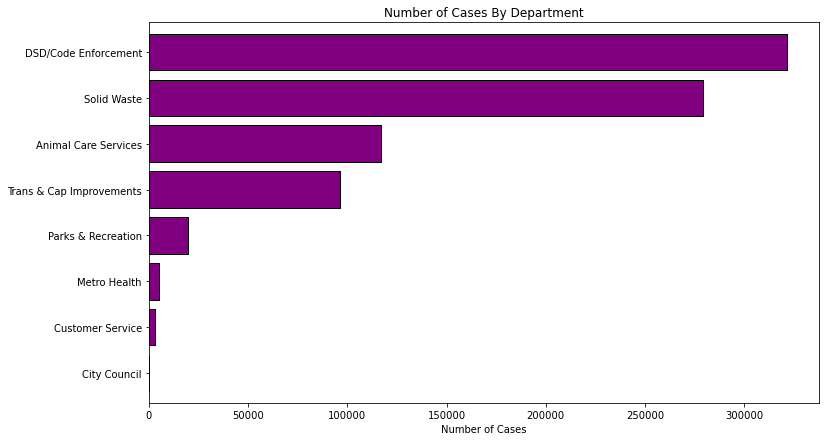

In [14]:
# First aggregate with spark
(
# group by    
    df.groupBy("department")
# aggregate by count    
    .count()
# then pass to pandas
    .toPandas()
# once its a dataframe, pass department as our index
    .set_index("department")["count"]
# sort our values for cleanliness of visualization
    .sort_values(ascending=True)
# pass our Series (department count values) to matplotlib
    .plot.barh(color = 'purple', width=.8, edgecolor="black", figsize=(12, 7))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

***
***
## Does the percentage of cases that are late vary by department?

In [15]:
# Does the percentage of cases that are late vary by department
df.groupby('department').pivot('case_late').count().fillna(0).show()

+--------------------+------+-----+
|          department| false| true|
+--------------------+------+-----+
|         Solid Waste|246325|32945|
|Animal Care Services| 93639|23276|
|Trans & Cap Impro...| 90782| 5411|
|    Customer Service|   839| 2010|
|  Parks & Recreation| 16110| 3797|
|        Metro Health|  4334|  829|
|        City Council|    33|    0|
|DSD/Code Enforcement|295139|26235|
+--------------------+------+-----+



In [17]:
# Finding all the late cases
late_cases = df.groupby('department').pivot('case_late').count().fillna(0)
# total counts
late_cases.withColumn('all', ( col('true') + col('false')) ).show()

+--------------------+------+-----+------+
|          department| false| true|   all|
+--------------------+------+-----+------+
|         Solid Waste|246325|32945|279270|
|Animal Care Services| 93639|23276|116915|
|Trans & Cap Impro...| 90782| 5411| 96193|
|    Customer Service|   839| 2010|  2849|
|  Parks & Recreation| 16110| 3797| 19907|
|        Metro Health|  4334|  829|  5163|
|        City Council|    33|    0|    33|
|DSD/Code Enforcement|295139|26235|321374|
+--------------------+------+-----+------+



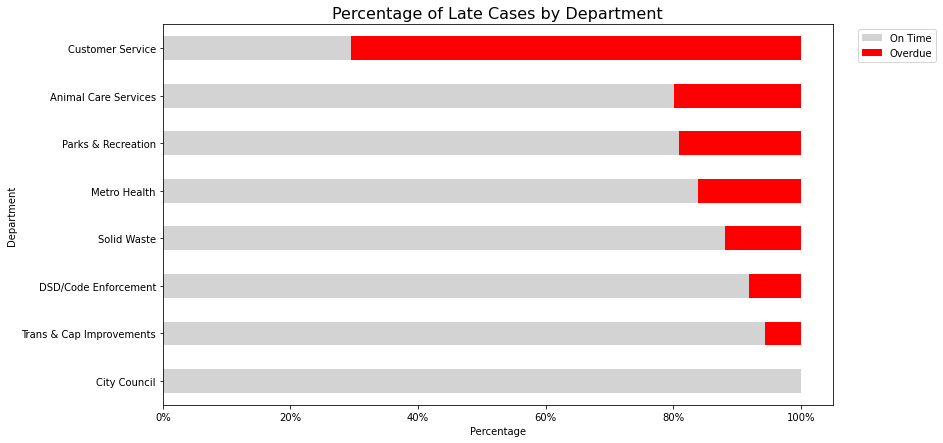

In [21]:
(
    # groupby Department
    df.groupby('department')
    
    # pivot on case late and count
    .pivot('case_late').count()
    .fillna(0)
    
    # create the all column
    .withColumn('all', col('true') + col('false') )
    
    # convert to pandas
    .toPandas()
    
    # set index to department for graphability
    .set_index('department')
    
    # apply function that calculates percentage for each row
    .apply(lambda row: row / row['all'], axis = 1)
    
    # drop the all column
    .drop(columns = 'all')
    
    # sort so highest percentage of late cases is at the top
    .sort_values(by = 'true')
    
    # plot as horizontal bar chart with custom colors
    .plot.barh(stacked = True, figsize = (12,7), color = ['lightgrey', 'red'])
)

plt.legend(labels = ['On Time', 'Overdue'], bbox_to_anchor = ((1.03, 1)))
plt.title('Percentage of Late Cases by Department', fontsize = 16)
plt.xlabel('Percentage')
plt.ylabel('Department')
# set x tick lables to percentage format
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter('{:.0%}'.format))

plt.show()

Moar liek customer disservice, amirite? City council has their cases on lock; fewest cases by a long shot, with 0% overall. 

***
***
## On average, how late are the late cases by department?

In [22]:
# On average, how late are the late cases by department?
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show()
)

+--------------------+------------------+
|          department|     avg_days_late|
+--------------------+------------------+
|    Customer Service| 87.68385942150394|
|DSD/Code Enforcement| 49.38428705358908|
|Animal Care Services|23.458633245820124|
|  Parks & Recreation|22.348910457867518|
|Trans & Cap Impro...|10.603064680316946|
|         Solid Waste| 7.186821906120899|
|        Metro Health|6.5438133155476494|
+--------------------+------------------+



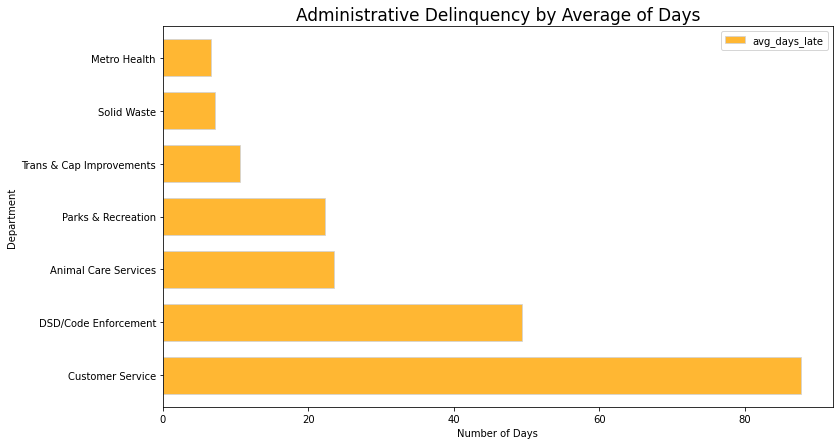

In [24]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('department').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('department')
    .plot.barh(width = .7, ec = 'lightgrey', alpha = .8, color = 'orange', figsize = (12,7))
)
plt.title("Administrative Delinquency by Average of Days", fontsize = 17)
plt.xlabel("Number of Days")
plt.ylabel("Department")
plt.show()

***
***
## What is the service type that is the most late?     
### Just for Parks & Rec?

In [25]:
# What is the service type that is the most late? Just for Parks & Rec?
# I can take the same approach, except grouping by the service type rather than dept
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509807|
|Donation Containe...|171.09115313942615|
|Storage of Used M...|163.96812829714287|
|Labeling for Used...|162.43032902285717|
|Record Keeping of...|153.99724039428568|
|Signage Requied f...|151.63868055333333|
|Traffic Signal Gr...|137.64583330000002|
|License Requied U...|128.79828704142858|
+--------------------+------------------+
only showing top 10 rows



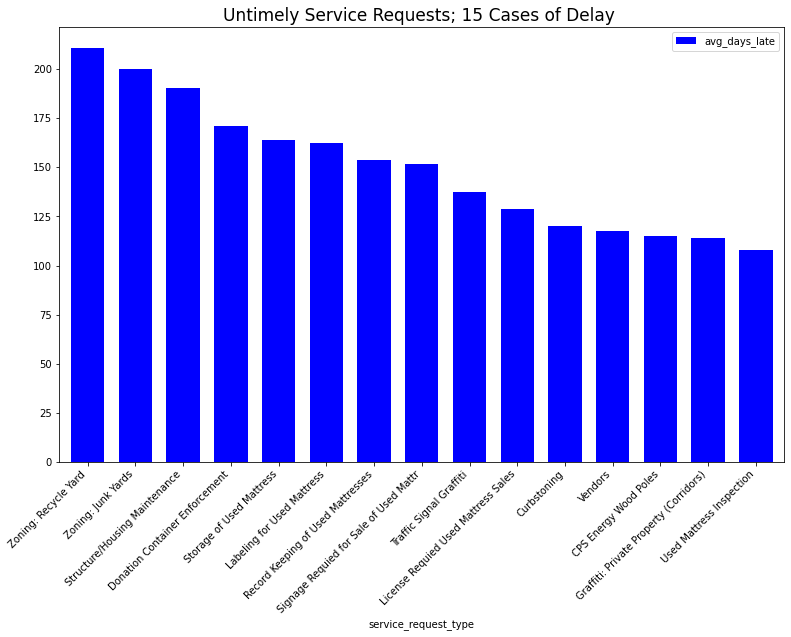

In [27]:
(
    df.filter(col('case_late') == 'true')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(15)
    .plot.bar(figsize = (13,8), width = .7, color = 'blue')
)
plt.xticks(rotation = 45, ha = 'right')
plt.title('Untimely Service Requests; 15 Cases of Delay ', fontsize = 17)
plt.show()

In [28]:
# specify for parks and recreation
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .show(10)
)

+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Amenity Park Impr...|    76.87018194568|
|Major Park Improv...| 75.79450367282354|
|Reservation Assis...|       66.03116319|
|Park Building Mai...|59.367469802695666|
| Sportfield Lighting|51.480049793645534|
|          Electrical|42.951971658345116|
|        Tree Removal| 40.28404224560715|
|Landscape Mainten...| 38.86797941326316|
|     Heavy Equipment| 38.56625730831579|
|Miscellaneous Par...| 33.62472491253488|
+--------------------+------------------+
only showing top 10 rows



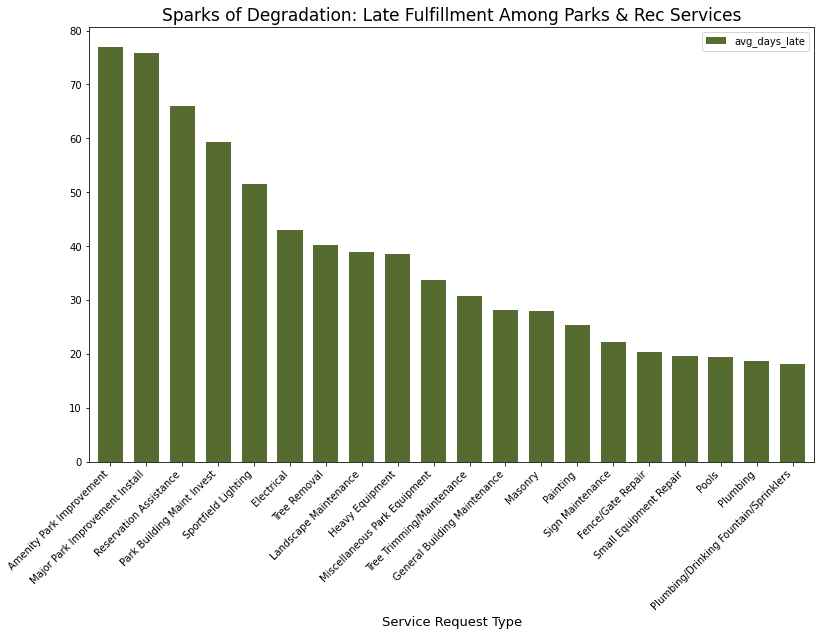

In [29]:
(
    df.filter(col('case_late') == 'true')
    .filter(col('department') == 'Parks & Recreation')
    .groupBy('service_request_type').agg(mean('num_days_late').alias('avg_days_late'))
    .sort(desc('avg_days_late'))
    .toPandas()
    .set_index('service_request_type')
    .head(20)
    .plot.bar(figsize = (13,8), width = .7, color = 'darkolivegreen')
)
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('Service Request Type', fontsize = 13)
plt.title('Sparks of Degradation: Late Fulfillment Among Parks & Rec Services', fontsize = 17)
plt.show()

***
***
## For the DSD/Code Enforcement department, what are the most common service request types?

In [30]:
# For the DSD/Code Enforcement department, what are the most common service request types?
(
    df.filter(col('department') == 'DSD/Code Enforcement')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .show(truncate = False)
)

+--------------------------------------+-----+
|service_request_type                  |count|
+--------------------------------------+-----+
|Overgrown Yard/Trash                  |65895|
|Bandit Signs                          |32910|
|Front Or Side Yard Parking            |28794|
|Junk Vehicle On Private Property      |21473|
|Alley-Way Maintenance                 |20214|
|Right Of Way/Sidewalk Obstruction     |17699|
|Vacant Lot/Overgrown/Trash            |9329 |
|Minimum Housing-Owner Occupied        |8543 |
|Graffiti: Private Property (Corridors)|8525 |
|Dang. Premises/CL/SEC                 |8004 |
|Minimum Housing-Tenant Occupied       |7984 |
|"Vacant Lot-Private (12"")"           |7875 |
|Brush Violations                      |7475 |
|Permits Building                      |6880 |
|Vacant House Overgrown Yard           |6109 |
|Graffiti: Building                    |4572 |
|Graffiti Public Property              |4104 |
|Low Hanging Limbs on Streets/Sidewalk |4052 |
|CPS Energy W

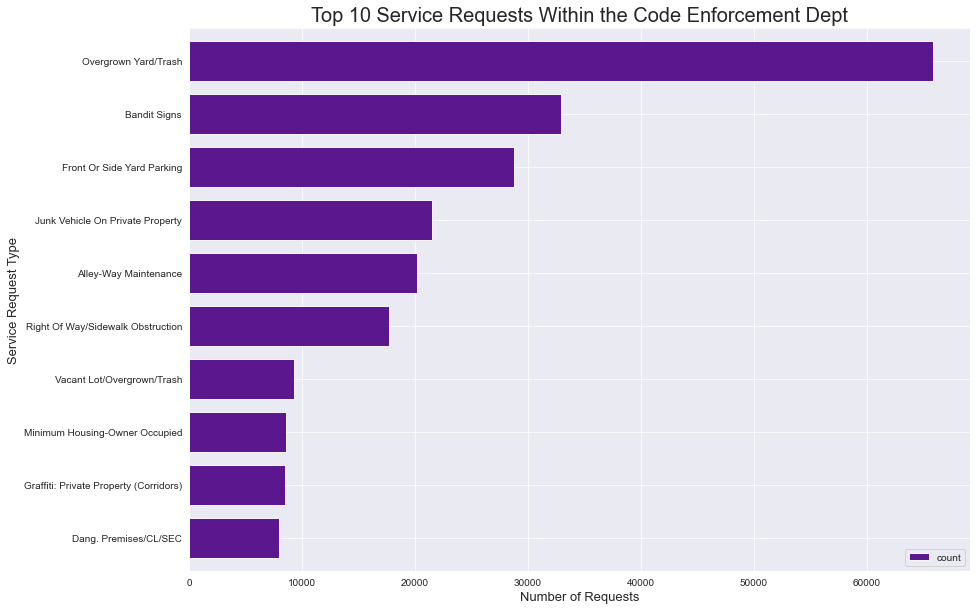

In [37]:
with sns.axes_style('darkgrid'):
    
    (
        df.filter(col('department') == 'DSD/Code Enforcement')
        .groupby('service_request_type').count()
        .sort(desc('count'))
        .toPandas()
        .set_index('service_request_type')
        .head(10)
        .sort_values(by = 'count', ascending = True)
        .plot.barh(figsize = (14,10), color = 'indigo', width = .75, ec = 'white', alpha = .9)
    )
    plt.title('Top 10 Service Requests Within the Code Enforcement Dept', fontsize = 20)
    plt.xlabel('Number of Requests', fontsize = 13)
    plt.ylabel('Service Request Type', fontsize = 13)
    plt.show()

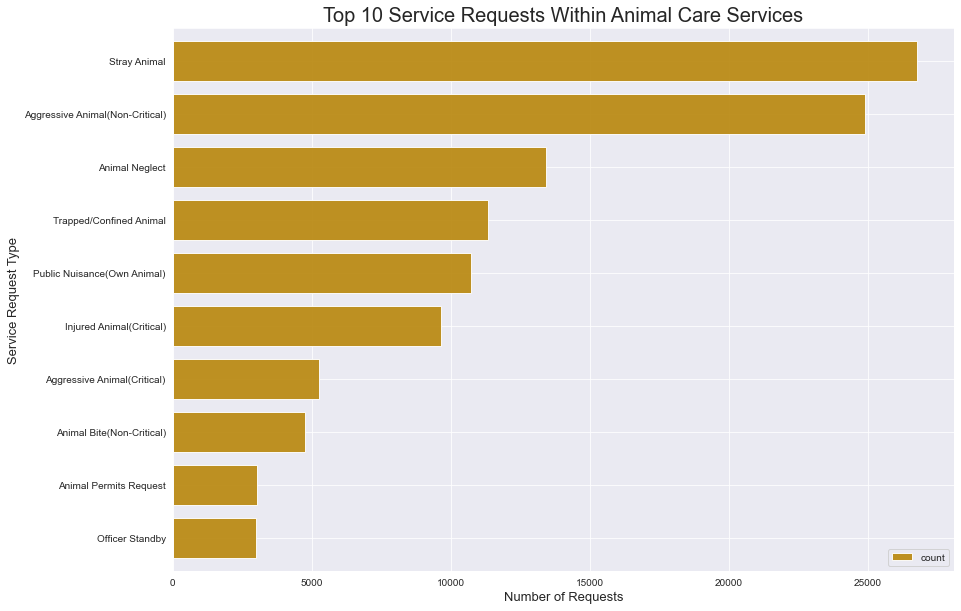

In [39]:
# checking out a different department
with sns.axes_style('darkgrid'):
    
    (
        df.filter(col('department') == 'Animal Care Services')
        .groupby('service_request_type').count()
        .sort(desc('count'))
        .toPandas()
        .set_index('service_request_type')
        .head(10)
        .sort_values(by = 'count', ascending = True)
        .plot.barh(figsize = (14,10), color = 'darkgoldenrod', width = .75, ec = 'white', alpha = .9)
    )
    plt.title('Top 10 Service Requests Within Animal Care Services', fontsize = 20)
    plt.xlabel('Number of Requests', fontsize = 13)
    plt.ylabel('Service Request Type', fontsize = 13)
    plt.show()

***
***
## Does whether or not its a weekend matter for when a case is opened/closed?

In [41]:
# Does whether or not its a weekend matter for when a case is opened/closed?
(
    df
    .groupby(date_format(col("case_opened_date"), "EEEE").alias('days_open'),
             dayofweek(col('case_opened_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .show()
)
# note that Sunday is being counted as the first day of the week. 
# This is usually the case, but some countries consider it to be Saturday
# and others mark monday as the beginning 

+---------+------------+------+
|days_open|numbered_day| count|
+---------+------------+------+
|   Sunday|           1| 28765|
|   Monday|           2|153104|
|  Tuesday|           3|161624|
|Wednesday|           4|147213|
| Thursday|           5|153724|
|   Friday|           6|143596|
| Saturday|           7| 53678|
+---------+------------+------+



In [42]:
(
    df
    .groupby(date_format(col("case_closed_date"), "EEEE").alias('days_closed'),
             dayofweek(col('case_closed_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .dropna()
    .show()
)

+-----------+------------+------+
|days_closed|numbered_day| count|
+-----------+------------+------+
|     Sunday|           1| 26867|
|     Monday|           2|135069|
|    Tuesday|           3|154916|
|  Wednesday|           4|170715|
|   Thursday|           5|145725|
|     Friday|           6|129142|
|   Saturday|           7| 61160|
+-----------+------------+------+



In [47]:
# turn to pandas for graphing 
open_days = (
    df
    .groupby(date_format(col("case_opened_date"), "EEEE").alias('weekday'),
             dayofweek(col('case_opened_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .toPandas()
)
print(f' These are the days where cases are opened: \n \n {open_days}')

closed_days = (
    df
    .groupby(date_format(col("case_closed_date"), "EEEE").alias('weekday'),
             dayofweek(col('case_closed_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .dropna()
    .toPandas()
)
print(f' These are the days where cases are closed: \n \n {closed_days}')

 These are the days where cases are opened: 
 
      weekday  numbered_day   count
0     Sunday             1   28765
1     Monday             2  153104
2    Tuesday             3  161624
3  Wednesday             4  147213
4   Thursday             5  153724
5     Friday             6  143596
6   Saturday             7   53678


 These are the days where cases are closed: 
 
      weekday  numbered_day   count
0     Sunday             1   26867
1     Monday             2  135069
2    Tuesday             3  154916
3  Wednesday             4  170715
4   Thursday             5  145725
5     Friday             6  129142
6   Saturday             7   61160


In [50]:
# bring it all together
all_dates = open_days.merge(closed_days, how = 'left', on = 'weekday')

#drop numbered_day
all_dates = all_dates.drop(columns = ['numbered_day_x', 'numbered_day_y'])


# set index to day and rename columns for clarity
all_dates = all_dates.set_index('weekday').rename(columns = {'count_x': 'case_opened_days', 'count_y': 'case_closed_days'})

# drop nulls, that's from cases not being closed yet
all_dates = all_dates.dropna()

all_dates

,case_opened_days,case_closed_days
weekday,,
Sunday,28765,26867
Monday,153104,135069
Tuesday,161624,154916
Wednesday,147213,170715
Thursday,153724,145725
Friday,143596,129142
Saturday,53678,61160


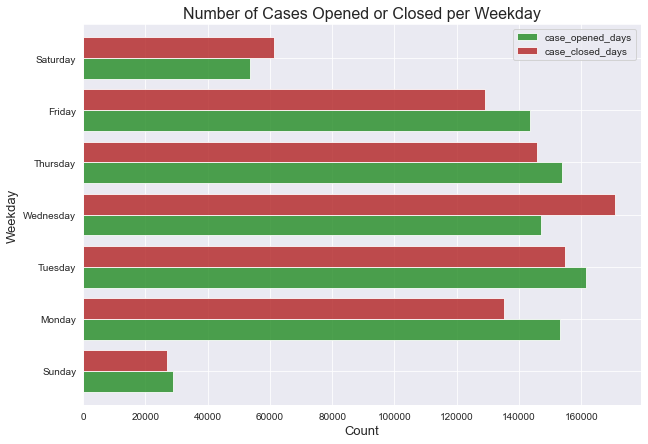

In [53]:
with sns.axes_style('darkgrid'):
    
    all_dates.plot.barh(figsize = (10,7), color = ['forestgreen', 'firebrick'], width = .8, alpha = .8)
    plt.title('Number of Cases Opened or Closed per Weekday', fontsize = 16)
    plt.xlabel('Count', fontsize = 13)
    plt.ylabel('Weekday', fontsize = 13)
    plt.show()

***
***
## On average, how many cases are opened a day for the Customer Service department?

In [ ]:
# On average, how many cases are opened a day for the Customer Service department?

In [54]:
(
    df
    .filter(col('department') == 'Customer Service')
    .groupby(col('case_opened_date'))
    .count()
    .select(mean('count'))
    .show()
)

+------------------+
|        avg(count)|
+------------------+
|1.0060028248587571|
+------------------+



In [ ]:
# One case per day.

***
***
## Does the number of service requests for the solid waste department vary by day of the week?

In [ ]:
# Does the number of service requests for the solid waste department vary by day of the week?

In [56]:
solid_waste = (
    df
    .filter(col('department') == 'Solid Waste')
    .groupby(date_format(col("case_opened_date"), "EEEE").alias('weekday'),
             dayofweek(col('case_opened_date')).alias('numbered_day'))
    .count()
    .sort(asc('numbered_day'))
    .dropna()
    .toPandas()
)
solid_waste['percent'] = solid_waste['count'] / solid_waste['count'].sum()
solid_waste

,weekday,numbered_day,count,percent
0,Sunday,1,6885,0.024654
1,Monday,2,58085,0.207989
2,Tuesday,3,58120,0.208114
3,Wednesday,4,41947,0.150202
4,Thursday,5,47718,0.170867
5,Friday,6,51203,0.183346
6,Saturday,7,15312,0.054829


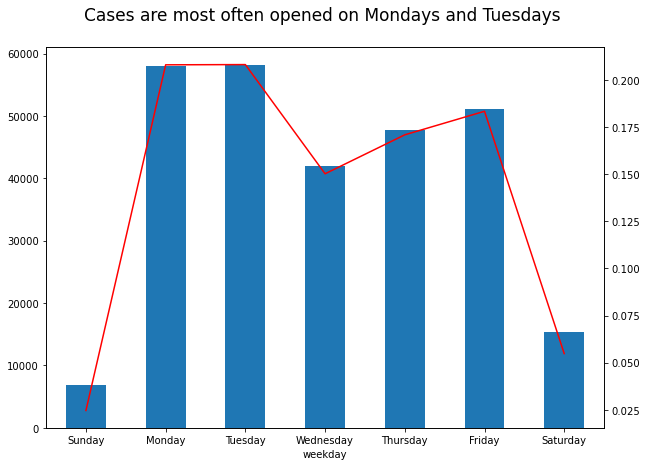

In [58]:
solid_waste.set_index('weekday')['count'].plot(kind='bar', figsize = (10,7))
solid_waste.set_index('weekday')['percent'].plot(secondary_y = True, color = 'red')

plt.title('Cases are most often opened on Mondays and Tuesdays \n', fontsize = 17)
plt.show()